# Lecture 17– Probability I

**by Will Fithian (Content credit: Lisa Yan)**

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# big font helper
def adjust_fontsize(size=None):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    if size != None:
        SMALL_SIZE = MEDIUM_SIZE = BIGGER_SIZE = size

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.style.use('fivethirtyeight')
sns.set_context("talk")
sns.set_theme()
#plt.style.use('default') # revert style to default mpl
adjust_fontsize(size=20)
%matplotlib inline


Plotting helper functions.

In [2]:
# helper functions to plot and 
# compute expectation, variance, standard deviation

def plot_dist(dist_df,
                      xname="x", pname="P(X = x)", varname="X",
                      save=False):
    """
    Plot a distribution from a distribution table.
    Single-variate.
    """
    plt.bar(dist_df[xname], dist_df[pname])
    plt.ylabel(pname)
    plt.xlabel(xname)
    plt.title(f"Distribution of ${varname}$")
    plt.xticks(sorted(dist_df[xname].unique()))
    if save:
        fig = plt.gcf()
        fig.patch.set_alpha(0.0)
        plt.savefig(f"dist{varname}.png", bbox_inches = 'tight');


def simulate_samples(df, xname="x", pname="P(X = x)", size=1):
    return np.random.choice(
                df[xname], # draw from these choiecs
                size=size, # this many times
                p=df[pname]) # according to this distribution

def simulate_iid_df(dist_df, nvars, rows, varname="X"):
    """
    Make an (row x nvars) dataframe
    by calling simulate_samples for each of the nvars per row
    """
    sample_dict = {}
    for i in range(nvars):
        # generate many datapoints 
        sample_dict[f"{varname}_{i+1}"] = \
            simulate_samples(dist_df, size=rows)
    return pd.DataFrame(sample_dict)


def plot_simulated_dist(df, colname, show_stats=True, save=False, **kwargs):
    """
    Plot a simulated population.
    """
    sns.histplot(data=df, x=colname, stat='probability', discrete=True, **kwargs)
    plt.xticks(sorted(df[colname].unique())) # if there are gaps)
    if show_stats:
        display(stats_df_multi(df, [colname]))
    if save:
        fig = plt.gcf()
        fig.patch.set_alpha(0.0)
        plt.savefig(f"sim{colname}.png", bbox_inches = 'tight');

def stats_df_multi(df, colnames):
    means = df[colnames].mean(axis=0)
    variances = df[colnames].var(axis=0)
    stdevs = df[colnames].std(axis=0)
    df_stats = pd.concat([means, variances, stdevs],axis=1).T
    df_stats['index_col'] = ["E[•]", "Var(•)", "SD(•)"]
    df_stats = df_stats.set_index('index_col', drop=True).rename_axis(None)
    return df_stats

def plot_simulated_dist_multi(df, colnames, show_stats=True):
    """
    If multiple columns provided, use separate plots.
    """
    ncols = 1
    nrows = len(colnames)
    plt.figure(figsize=(6, 2*nrows+2))
    
    for i, colname in enumerate(colnames):
        subplot_int = int(100*int(nrows) + 10*int(ncols) + int(i+1))
        plt.subplot(subplot_int)
        plot_simulated_dist(df, colname, show_stats=False)
    plt.tight_layout()
    if show_stats:
        display(stats_df_multi(df, colnames))

---

## A Random Variable $X$

Our probability distribution of $X$, shown as a table:

## Flipping coins

Data set containing the two possible outcomes of flipping a (fair) coin


In [16]:
fair_coin = pd.DataFrame({"Outcome": ["H","T"]})
fair_coin

,Outcome
0,H
1,T


We can flip the coin once. The outcome is *random*: it comes out (potentially) differently each time we re-evaluate the cell.

In [43]:
fair_coin.sample(1)

,Outcome
0,H


Or ten times, to get a *sample* $s$ of 10 flips:

In [242]:
s = fair_coin.sample(10, replace=True)
s

,Outcome
1,T
0,H
1,T
1,T
1,T
0,H
0,H
1,T
0,H
1,T


Instead of showing the whole sample $s$, we can just show how many heads, which we'll call $X(s)$

Because $s$ is random, so is $X(s)$ (or any function of $s$)

In [257]:
s = fair_coin.sample(10, replace = True)
X = sum(s["Outcome"] == "H")
X

8

Questions we might ask about $X(s)$:

1. How likely is it to take some particular value $x$?
2. How big is it on average?
3. How much does it typically vary around that average?

Mathematically, these questions can be answered with 
1. The distribution of $X$
2. The expectation $\mathbb{E}(X)$
3. The variance $\text{Var}(X)$

One way to answer this question is to simulate it many times:

In [236]:
n_flips = 20
n_sim = 10000
X_sim = list()
for i in range(n_sim):
    s = fair_coin.sample(n_flips, replace = True)
    X_sim.append(sum(s["Outcome"] == "T"))

In [237]:
sim_results = pd.DataFrame({"X": X_sim})
sim_results

,X
0,10
1,14
2,12
3,9
4,11
...,...
9995,9
9996,11
9997,9
9998,10


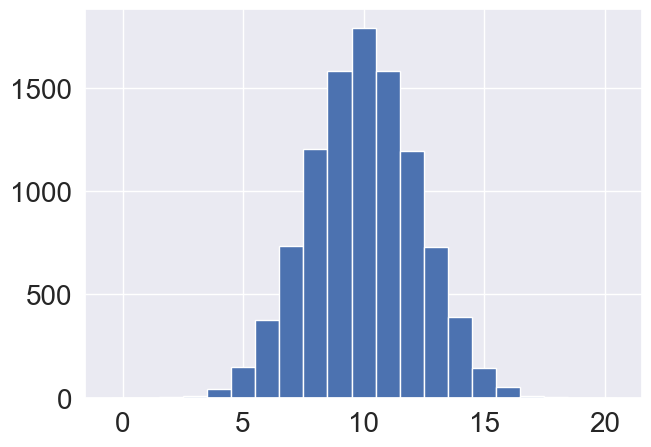

In [238]:
plt.hist(X_sim,
         bins=np.arange(-0.5,n_flips+0.6, 
                        np.ceil(np.sqrt(n_flips)/5)));

In [239]:
sim_results.value_counts() / n_sim

X 
10    0.1792
9     0.1581
11    0.1581
8     0.1204
12    0.1194
7     0.0735
13    0.0728
14    0.0393
6     0.0378
5     0.0149
15    0.0145
16    0.0051
4     0.0042
17    0.0010
3     0.0009
18    0.0006
2     0.0002
dtype: float64

In [240]:
np.mean(X_sim)

10.0092

In [241]:
np.var(X_sim)

5.039715359999998

## Generic (discrete) distribution 

In [3]:
# our random variable X
dist_df = pd.DataFrame({"x": [3, 4, 6, 8],
                        "P(X = x)": [0.1, 0.2, 0.4, 0.3]})
dist_df

,x,P(X = x)
0,3,0.1
1,4,0.2
2,6,0.4
3,8,0.3


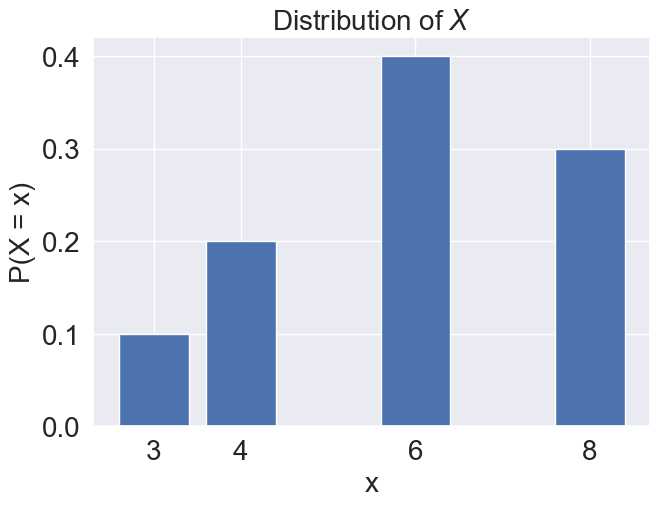

In [4]:
plot_dist(dist_df, save=True)

Let's use this probability distribution to generate a table of $X(s)$, i.e., random variable values for many many samples.

In [5]:
# copied from above
# def simulate_samples(df, xname="x", pname="P(X = x)", size=1):
#     return np.random.choice(
#                 df[xname], # draw from these choiecs
#                 size=size, # this many times
#                 p=df[pname]) # according to this distribution

N = 80000
all_samples = simulate_samples(dist_df, size=N)
sim_df = pd.DataFrame({"X(s)": all_samples})
sim_df

,X(s)
0,6
1,4
2,6
3,6
4,4
...,...
79995,6
79996,8
79997,8
79998,6


<br/><br/>
Let's check how well this simulated sample matches our probability distribution!

,X(s)
E[•],5.887012
Var(•),2.890907
SD(•),1.700267


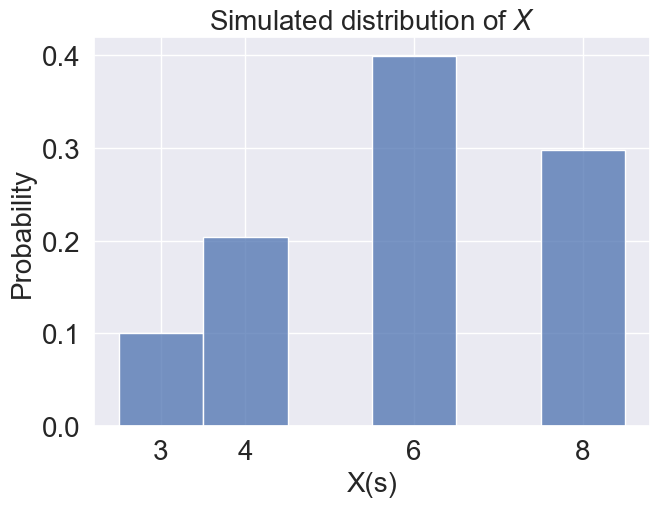

In [6]:
plot_simulated_dist(sim_df, "X(s)")
plt.title("Simulated distribution of $X$")
plt.show()

In [8]:
# the tabular view of the above plot
sim_df.value_counts("X(s)").sort_values()/N

X(s)
3    0.099988
4    0.203725
8    0.297212
6    0.399075
dtype: float64

<br/><br/>

---

# Die Is the Singular; Dice Is the Plural

Let X be the outcome of a single die roll. X is a random variable.

In [9]:
# our random variable X
roll_df = pd.DataFrame({"x": [1, 2, 3, 4, 5, 6],
                        "P(X = x)": np.ones(6)/6})
roll_df

,x,P(X = x)
0,1,0.166667
1,2,0.166667
2,3,0.166667
3,4,0.166667
4,5,0.166667
5,6,0.166667


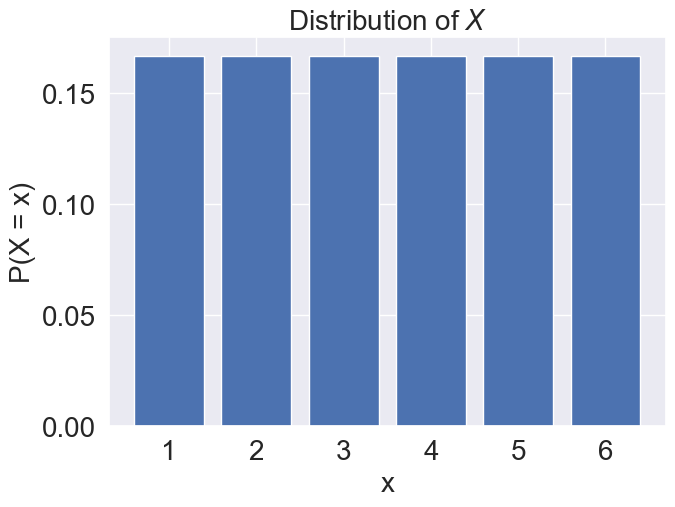

In [10]:
plot_dist(roll_df)

<br/><br/>

---

# Sum of 2 Dice Rolls

Here's the distribution of a single die roll:

In [11]:
roll_df = pd.DataFrame({"x": [1, 2, 3, 4, 5, 6],
                        "P(X = x)": np.ones(6)/6})
roll_df

,x,P(X = x)
0,1,0.166667
1,2,0.166667
2,3,0.166667
3,4,0.166667
4,5,0.166667
5,6,0.166667



Let $X_1, X_2$ are the outcomes of two dice rolls. Note $X_1$ and $X_2$ are i.i.d. (independent and identically distributed).

Below I call a helper function `simulate_iid_df`, which simulates an 80,000-row table of $X_1, X_2$ values. It uses `np.random.choice(arr, size, p)` [link](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) where `arr` is the array the values and `p` is the probability associated with choosing each value. If you're interested in the implementation details, scroll up.

In [12]:
N = 80000
sim_rolls_df = simulate_iid_df(roll_df, nvars=2, rows=N)
sim_rolls_df

,X_1,X_2
0,4,5
1,1,3
2,2,6
3,1,4
4,6,3
...,...,...
79995,6,6
79996,1,5
79997,1,3
79998,5,5


Define the following random variables, which are functions of $X_1$ and $X_2$:
* $Y = X_1 + X_1 = 2 X_1$
* $Z = X_1 + X_2$

We can use our simulated values of $X_1, X_2$ to create new columns $Y$ and $Z$:

In [12]:
sim_rolls_df['Y'] = 2 * sim_rolls_df['X_1']
sim_rolls_df['Z'] = sim_rolls_df['X_1'] + sim_rolls_df['X_2']
sim_rolls_df

,X_1,X_2,Y,Z
0,2,4,4,6
1,5,4,10,9
2,3,4,6,7
3,6,6,12,12
4,2,5,4,7
...,...,...,...,...
79995,6,5,12,11
79996,1,4,2,5
79997,4,3,8,7
79998,6,4,12,10


Now that we have simulated samples of $Y$ and $Z$, we can plot histograms to see their distributions!

<br/>
Distribution of $Y$, which was twice the value of our first die roll:

,Y
E[•],6.999625
Var(•),11.688446
SD(•),3.418837


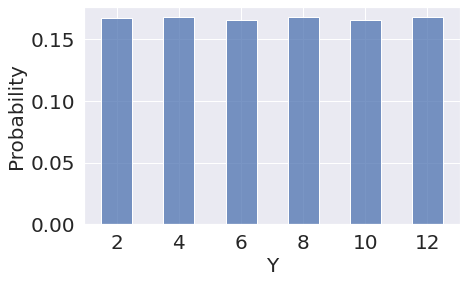

In [13]:
plot_simulated_dist(sim_rolls_df, "Y", save=True)

Distribution of $Z$, the sum of two IID dice rolls:

,Z
E[•],7.003800
Var(•),5.848734
SD(•),2.418416


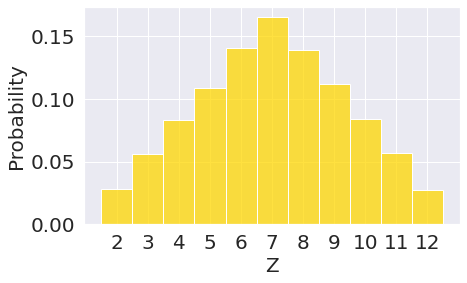

In [14]:
plot_simulated_dist(sim_rolls_df, "Z", save=True, color='gold')

Let's compare the expectations and variances of these simulated distributions of $Y$ and $Z$.
* We computed:
    * $\mathbb{E}[Y]$ as `np.mean(sim_rolls_df['Y'])`
    * $\text{Var}(Y)$ as `np.var(sim_rolls_df['Y']`
    * etc.
* The larger your simulated rows $N$, the closer the simulated expectation will be to the true expectation.
* Our approach is tedious--we have to simulate an entire population, then reduce it down to expectation/variance/standard deviation. There has to be a better way!

In [27]:
stats_df_multi(sim_rolls_df, ["Y", "Z"])

,Y,Z
E[•],7.013375,7.002725
Var(•),11.722368,5.870866
SD(•),3.423794,2.422987


In [37]:
# Flip 20 iid coins, each exactly once
flips20_df = simulate_iid_df(coin_df, nvars=20, rows=1)

# Construct Y_B from this sample
flips20_df["Y_B"] = flips20_df.sum(axis=1) # sum all coins

display(flips20_df)
print("Y_B:", flips20_df.loc[0,"Y_B"])

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,Y_B
0,0,1,0,1,0,0,1,1,0,0,...,1,0,0,1,1,0,0,0,0,8


Y_B: 8


<br/><br/><br/>

---

# From Population to Sample

Remember the population distribution we looked at earlier:

In [61]:
dist_df

,x,P(X = x)
0,3,0.1
1,4,0.2
2,6,0.4
3,8,0.3


In [96]:
# a population generated from the distribution
N = 100000
all_samples = simulate_samples(dist_df, size=N)
sim_pop_df = pd.DataFrame({"X(s)": all_samples})
sim_pop_df

,X(s)
0,6
1,8
2,8
3,4
4,8
...,...
99995,6
99996,8
99997,8
99998,8


<br/><br/><br/>
Suppose we draw a sample of size 100 from this giant population.

We are performing **Random Sampling with Replacement:** `df.sample(n, replace=True)` ([link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html))

In [84]:
n = 100      # size of our sample
sample_df = (
             sim_pop_df.sample(n, replace=True)
             
             # some reformatting below
             .reset_index(drop=True)
             .rename(columns={"X(s)": "X"})
            )
sample_df

,X
0,6
1,8
2,6
3,6
4,3
...,...
95,8
96,6
97,6
98,3


Our **sample distribution** (n = 100):

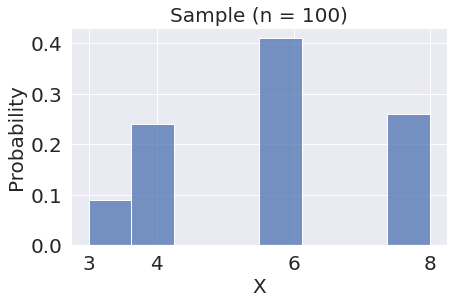

Mean of Sample: 5.77


In [101]:
sns.histplot(data=sample_df, x='X', stat='probability')
plt.xticks([3, 4, 6, 8])
plt.title(f"Sample (n = 100)")
plt.show()

print("Mean of Sample:", np.mean(sample_df['X']))

<br/>

Compare this to our **original population** (N = 80,000):

,X(s)
E[•],5.893600
Var(•),2.888465
SD(•),1.699549


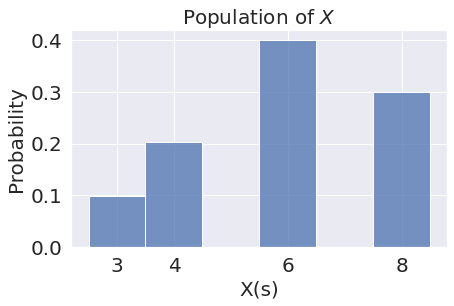

In [97]:
plot_simulated_dist(sim_df, "X(s)")
plt.title("Population of $X$")
plt.show()